# Connect to IBMQ and specify the target backend

In [3]:
from qiskit import IBMQ, assemble, transpile
from qiskit import QuantumCircuit
from qiskit.circuit.random import random_circuit

provider = IBMQ.load_account()
#backend  = provider.backend.ibm_oslo
#qpconfig = backend.configuration().to_dict()
#print(qpconfig)

RequestsApiError: '401 Client Error: Unauthorized for url: https://auth.quantum-computing.ibm.com/api/users/loginWithToken. Login failed., Error code: 3446.'

In [2]:
backends_listed = []
for name in provider.backend.backends():
    status = name.status()
    if status.status_msg=='active':
        backends_listed.append(
            (name, status.pending_jobs)
        )

NameError: name 'provider' is not defined

In [3]:
backend, n_jobs = sorted(backends_listed, key=lambda x:x[1])[0]
print(f'The least active backend is {backend} with {n_jobs} job(s) in the queue.')

The least active backend is ibmq_armonk with 4 job(s) in the queue.


In [4]:
qpconfig = backend.configuration().to_dict()
print(qpconfig)

{'backend_name': 'ibmq_armonk', 'backend_version': '2.4.35', 'n_qubits': 1, 'basis_gates': ['id', 'rz', 'sx', 'x'], 'gates': [{'name': 'id', 'parameters': [], 'qasm_def': 'gate id q { U(0, 0, 0) q; }', 'coupling_map': [[0]]}, {'name': 'rz', 'parameters': ['theta'], 'qasm_def': 'gate rz(theta) q { U(0, 0, theta) q; }', 'coupling_map': [[0]]}, {'name': 'sx', 'parameters': [], 'qasm_def': 'gate sx q { U(pi/2, 3*pi/2, pi/2) q; }', 'coupling_map': [[0]]}, {'name': 'x', 'parameters': [], 'qasm_def': 'gate x q { U(pi, 0, pi) q; }', 'coupling_map': [[0]]}], 'local': False, 'simulator': False, 'conditional': False, 'open_pulse': True, 'memory': True, 'max_shots': 20000, 'coupling_map': None, 'dynamic_reprate_enabled': False, 'supported_instructions': ['measure', 'rz', 'id', 'u2', 'sx', 'delay', 'play', 'shiftf', 'acquire', 'u1', 'x', 'setf', 'u3'], 'max_experiments': 100, 'sample_name': 'family: Canary, revision: 1.2', 'n_registers': 1, 'credits_required': True, 'online_date': datetime.datetime

# Build a quantum circuit to be submitted to the backend

In [5]:
n_qubits = qpconfig['n_qubits']
qc = QuantumCircuit(n_qubits)
for i in range(n_qubits):
    qc.h(i)
qc.measure_all()
qc.draw()

┌───┐ ░ ┌─┐
   q_0: ┤ H ├─░─┤M├
        └───┘ ░ └╥┘
meas: 1/═════════╩═
                 0

each quantum processor will have a set of native gates it recognises - the quantum circuit above may contain gates that are not directly supported. Transpilation decomposes the circuit into native gates.

In [6]:
transpiled = transpile(qc, backend=backend)
transpiled.draw()

/home/tweaving/.local/lib/python3.8/site-packages/sympy/core/expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


global phase: π/4
        ┌─────────┐┌────┐┌─────────┐ ░ ┌─┐
   q_0: ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░─┤M├
        └─────────┘└────┘└─────────┘ ░ └╥┘
meas: 1/════════════════════════════════╩═
                                        0

# Create a job from the transpiled circuit and submit to the backend

In [7]:
job = backend.run(transpiled)

Various features of the job progress can be monitored, such as its position in the queue or whether it has been completed.

In [46]:
print(f'Job ID: {job.job_id()}')
print(f'Queue position: {job.queue_position()}')
print(f'Executing job?  {job.running()}')
print(f'Completed job?  {job.done()}')

Job ID: 62ac95af900bfe1d1d32ff1b
Queue position: None
Executing job?  False
Completed job?  True


# Once complete, the results may be retrieved

In [47]:
retrieved_job = backend.retrieve_job(job.job_id())
result = retrieved_job.result()

In [48]:
result.to_dict()

{'backend_name': 'ibmq_armonk',
 'backend_version': '2.4.35',
 'qobj_id': '875b2b31-b2bb-4416-92c5-10c1d12274fe',
 'job_id': '62ac95af900bfe1d1d32ff1b',
 'success': True,
 'results': [{'shots': 4000,
   'success': True,
   'data': {'counts': {'0x0': 2038, '0x1': 1962}},
   'meas_level': 2,
   'header': {'qubit_labels': [['q', 0]],
    'n_qubits': 1,
    'qreg_sizes': [['q', 1]],
    'clbit_labels': [['meas', 0]],
    'memory_slots': 1,
    'creg_sizes': [['meas', 1]],
    'name': 'circuit-0',
    'global_phase': 0.7853981633974483,
    'metadata': {}}}],
 'date': datetime.datetime(2022, 6, 17, 15, 58, 12, tzinfo=tzlocal()),
 'status': 'Successful completion',
 'header': {'backend_name': 'ibmq_armonk', 'backend_version': '2.4.35'},
 'execution_id': 'dbdd414e-ee4d-11ec-9b61-b02628f7f59e',
 'time_taken': 21.234611988067627,
 'error': None,
 'client_version': {'qiskit': '0.32.1'}}

Qiskit has a number of quantum state visualization tools, such as histogram:

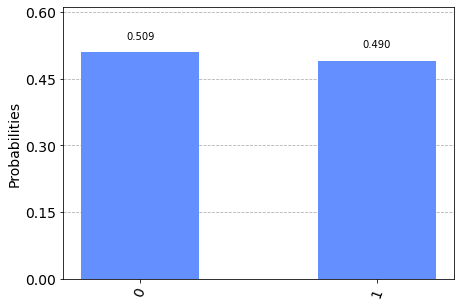

In [49]:
from qiskit.visualization import plot_histogram
plot_histogram(result.get_counts())

# Now let's run a CS-VQE simulation

In [31]:
import json
with open('../data/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)
print(molecule_geometries.keys())

dict_keys(['H2_3-21G_SINGLET', 'H6_STO-3G_SINGLET', 'H2_6-31G_SINGLET', 'H2_6-311G_SINGLET', 'H3+_STO-3G_SINGLET', 'H3+_3-21G_SINGLET', 'HeH+_3-21G_SINGLET', 'HeH+_6-311G_SINGLET', 'H2O_STO-3G_SINGLET', 'BeH+_STO-3G_SINGLET', 'LiOH_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'NaH_STO-3G_SINGLET', 'LiH_3-21G_SINGLET', 'CH+_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'HF_3-21G_SINGLET', 'B+_STO-3G_SINGLET', 'B_STO-3G_DOUBLET', 'N_STO-3G_QUARTET', 'OH-_STO-3G_SINGLET', 'O_STO-3G_TRIPLET', 'CH2_STO-3G_TRIPLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'C_STO-3G_TRIPLET', 'NH_STO-3G_SINGLET', 'Ne_STO-3G_SINGLET', 'F_STO-3G_DOUBLET', 'Li_STO-3G_DOUBLET', 'BH_STO-3G_SINGLET', 'NeH+_STO-3G_SINGLET', 'NH2-_STO-3G_SINGLET', 'BH3_STO-3G_SINGLET', 'BH2+_STO-3G_SINGLET', 'HCl_STO-3G_SINGLET', 'H4_STO-3G_SINGLET', 'NH3_STO-3G_SINGLET', 'NH4+_STO-3G_SINGLET', 'MgH2_STO-3G_SINGLET', 'Mg_STO-3G_SINGLET', 'F2_STO-3G_SINGLET', 'HCN_STO-3G_SINGLET', 'CH4_STO-3G_SINGLET', 'CH3NHCH3_STO-3G_SINGLET', 'CH3CH2NH2_STO-

Build the molecule:

In [32]:
from symmer.chem import MoleculeBuilder
from symmer.projection import QubitTapering, CS_VQE, StabilizerIdentification

speciesname = 'Be_STO-3G_SINGLET'
print(speciesname)
# build the molecule
mol_data = molecule_geometries[speciesname]
atoms  = mol_data['atoms']
coords = mol_data['coords']
charge = mol_data['charge']
basis = mol_data['basis']
geometry = list(zip(atoms, coords))
molecule = MoleculeBuilder(geometry=geometry, charge=charge, basis=basis, spin=0, run_fci=True, print_info=True)

Be_STO-3G_SINGLET
Molecule geometry:
Be	0	0	0

HF converged?   True
CCSD converged? True
FCI converged?  True

HF energy:   -14.351880476202023
MP2 energy:  -14.376238850841515
CCSD energy: -14.403650751752787
FCI energy:  -14.403655108067682


Number of qubits: 10


Taper the Hamiltonian:

In [33]:
# taper the Hamiltonian
qubit_tapering = QubitTapering(molecule.H_q)
hf_array = molecule.H_fermion.hf_comp_basis_state
qubit_tapering.stabilizers.update_sector(hf_array)
ham_tap = qubit_tapering.taper_it(ref_state=hf_array)
ucc_tap = qubit_tapering.taper_it(aux_operator=molecule.T_q, ref_state=hf_array)
hf_tapered = qubit_tapering.tapered_ref_state

print(f'Qubit tapering permitted a reduction of {molecule.H_q.n_qubits} -> {ham_tap.n_qubits} qubits\n')
print('The following stabilizers were identified:\n')
print(qubit_tapering.stabilizers)

Qubit tapering permitted a reduction of 10 -> 5 qubits

The following stabilizers were identified:

 1 ZIZIIZIZIZ 
 1 IZIZIZIZIZ 
 1 IIIIZZIIII 
 1 IIIIIIZZII 
 1 IIIIIIIIZZ


Build CS-VQE model and find optimal stabilizers:

In [36]:
n_qubits = 3
# CS-VQE and stabilizer identification
cs_vqe = CS_VQE(ham_tap, hf_tapered, basis_weighting_operator=ucc_tap, noncontextual_form='diag')
CC_stabilizers = StabilizerIdentification(ucc_tap)
S = CC_stabilizers.symmetry_basis_by_subspace_dimension(n_qubits)
ham_cs = cs_vqe.project_onto_subspace(S, enforce_clique_operator=False)

In [37]:
ham_cs.to_PauliSumOp

PauliSumOp(SparsePauliOp(['III', 'IIZ', 'IZI', 'IZZ', 'ZII', 'ZIZ', 'ZZI', 'ZZZ', 'IIX', 'ZZX', 'IXI', 'ZXZ', 'IXX', 'IYY', 'XII', 'XZZ', 'XIX', 'YIY', 'XXI', 'YYI'],
              coeffs=[-12.488598  +0.j,  -0.85829425+0.j,  -0.85829425+0.j,   0.02304318+0.j,
  -0.85829425+0.j,   0.02304318+0.j,   0.02304318+0.j,   0.64247074+0.j,
  -0.04340449+0.j,  -0.04340449+0.j,  -0.04340449+0.j,  -0.04340449+0.j,
   0.01212469+0.j,   0.01212469+0.j,  -0.04340449+0.j,  -0.04340449+0.j,
   0.01212469+0.j,   0.01212469+0.j,   0.01212469+0.j,   0.01212469+0.j]), coeff=1.0)

# Build an Ansatz

In [39]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(num_qubits=n_qubits, reps=1, entanglement="linear", insert_barriers=True)
ansatz.decompose().draw()#"mpl", style="iqx")

┌──────────┐┌──────────┐ ░            ░ ┌──────────┐ ┌──────────┐
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[3]) ├─░───■────────░─┤ Ry(θ[6]) ├─┤ Rz(θ[9]) ├
     ├──────────┤├──────────┤ ░ ┌─┴─┐      ░ ├──────────┤┌┴──────────┤
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[4]) ├─░─┤ X ├──■───░─┤ Ry(θ[7]) ├┤ Rz(θ[10]) ├
     ├──────────┤├──────────┤ ░ └───┘┌─┴─┐ ░ ├──────────┤├───────────┤
q_2: ┤ Ry(θ[2]) ├┤ Rz(θ[5]) ├─░──────┤ X ├─░─┤ Ry(θ[8]) ├┤ Rz(θ[11]) ├
     └──────────┘└──────────┘ ░      └───┘ ░ └──────────┘└───────────┘

# Define the classical optimizer for VQE

# Initiate the Qiskit VQE object and run

In [12]:
from qiskit_nature.runtime import VQEProgram

# Pass an qiskit.algorithms.optimizer.Optimizer object (like the ``optimizer`` variable from before)
# or SPSA/QN-SPSA as dictionary. Here we're using the dictionary version
optimizer = {
    "name": "QN-SPSA",  # leverage the Quantum Natural SPSA
    # 'name': 'SPSA',  # set to ordinary SPSA
    "maxiter": 100,
    "resamplings": {1: 100},  # 100 samples of the QFI for the first step, then 1 sample per step
}

In [13]:
runtime_vqe = VQEProgram(
    ansatz=ansatz,
    optimizer=optimizer,
    initial_point=initial_point,
    provider=provider,
    backend=backend,
    shots=1024,
    measurement_error_mitigation=True
)

NameError: name 'initial_point' is not defined

In [59]:
vqe_job = runtime_vqe.compute_minimum_eigenvalue(operator=ham_cs.to_PauliSumOp)

KeyboardInterrupt: 

In [60]:
print(f'Job ID: {vqe_job.job_id()}')
print(f'Queue position: {vqe_job.queue_position()}')
print(f'Executing job?  {vqe_job.running()}')
print(f'Completed job?  {vqe_job.done()}')

NameError: name 'vqe_job' is not defined

In [ ]:
retrieved_job = backend.retrieve_job(vqe_job.job_id())
result = retrieved_job.result()

In [ ]:
result.to_dict()

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService
#token = "79d7ac8b5e8ccb0dc53055b301ee7f02eaa147024039f20d1c5af280fc066c6426739e194af6f7fa44c27004aa7ed9a22df031085512b2f97d77207b9c2534fb"
#QiskitRuntimeService.save_account(channel="ibm_quantum", token=token)

In [18]:
service = QiskitRuntimeService(channel='ibm_quantum')

In [29]:
for name in service.backends():
    print(f'{name.name} backend has {name.status().pending_jobs} queued jobs.')

ibmq_qasm_simulator backend has 15 queued jobs.
ibmq_armonk backend has 0 queued jobs.
ibmq_santiago backend has 84 queued jobs.
ibmq_bogota backend has 248 queued jobs.
ibmq_lima backend has 28 queued jobs.
ibmq_belem backend has 24 queued jobs.
ibmq_quito backend has 29 queued jobs.
simulator_statevector backend has 16 queued jobs.
simulator_mps backend has 16 queued jobs.
simulator_extended_stabilizer backend has 16 queued jobs.
simulator_stabilizer backend has 16 queued jobs.
ibmq_manila backend has 232 queued jobs.
ibm_oslo backend has 10 queued jobs.


In [70]:
from qiskit_ibm_runtime import QiskitRuntimeService
backend_name = 'simulator_statevector'
options = {
    'backend_name': backend_name
}

optimizer = {
    "name": "QN-SPSA",  # leverage the Quantum Natural SPSA
    # 'name': 'SPSA',  # set to ordinary SPSA
    "maxiter": 100,
    "resamplings": {1: 100},  # 100 samples of the QFI for the first step, then 1 sample per step
}

runtime_inputs = {
    'ansatz': ansatz,
    'initial_parameters': None,
    'operator': ham_cs.to_PauliSumOp,
    'optimizer': optimizer,
    # 'aux_operators': None, # array
    # 'initial_layout': None, # [null,array,object]
    'measurement_error_mitigation': True, # boolean
    # 'shots': 1024 # integer
}

job = service.run(
    program_id='vqe',
    options=options,
    inputs=runtime_inputs,
    instance='ibm-q/open/main'
)

In [82]:
print(f'Job ID: {job.job_id}')
print(f'Job staus: {job.status()}')

Job ID: cam9rsct0i3e1o6f4b1g
Job staus: JobStatus.ERROR


In [83]:
job.interim_results()

In [84]:
# Get results
result = job.result()
result['optimal_value']

RuntimeJobFailureError: 'Unable to retrieve job result. Job cam9rsct0i3e1o6f4b1g has failed:\n2022-06-17T15:29:58.625666702Z 06/17/2022 03:29:58 PM - jaeger_tracing - INFO Initializing Jaeger Tracer with UDP reporter\n2022-06-17T15:29:58.631674293Z 06/17/2022 03:29:58 PM - jaeger_tracing - INFO Using sampler ConstSampler(True)\n2022-06-17T15:29:58.632497629Z 06/17/2022 03:29:58 PM - jaeger_tracing - INFO opentracing.tracer initialized to <jaeger_client.tracer.Tracer object at 0x7fb993fe36d0>[app_name=ntc-job]\n2022-06-17T15:29:58.633764519Z 06/17/2022 03:29:58 PM - programruntime.program_starter_wrapper - INFO Executing program.py (job cam9rsct0i3e1o6f4b1g)\n2022-06-17T15:29:58.641203124Z --- Logging error ---\n2022-06-17T15:29:58.641214822Z Traceback (most recent call last):\n2022-06-17T15:29:58.641219581Z   File "/provider/programruntime/program_starter_wrapper.py", line 70, in execute\n2022-06-17T15:29:58.641227232Z     final_result = self.main(backend, self.messenger, **self.user_params)\n2022-06-17T15:29:58.641232333Z   File "/code/program.py", line 1144, in main\n2022-06-17T15:29:58.641237137Z     _quantum_instance = QuantumInstance(\n2022-06-17T15:29:58.641242045Z   File "/usr/local/lib/python3.8/site-packages/qiskit/utils/quantum_instance.py", line 332, in __init__\n2022-06-17T15:29:58.641246747Z     raise QiskitError(\n2022-06-17T15:29:58.641251357Z qiskit.exceptions.QiskitError: \'Measurement error mitigation does not work with the statevector simulation.\'\n2022-06-17T15:29:58.641255789Z \n2022-06-17T15:29:58.641260262Z During handling of the above exception, another exception occurred:\n2022-06-17T15:29:58.641270460Z \n2022-06-17T15:29:58.641274343Z Traceback (most recent call last):\n2022-06-17T15:29:58.641280236Z   File "/usr/local/lib/python3.8/logging/__init__.py", line 1085, in emit\n2022-06-17T15:29:58.641284825Z     msg = self.format(record)\n2022-06-17T15:29:58.641288419Z   File "/usr/local/lib/python3.8/logging/__init__.py", line 929, in format\n2022-06-17T15:29:58.641289674Z     return fmt.format(record)\n2022-06-17T15:29:58.641294207Z   File "/usr/local/lib/python3.8/logging/__init__.py", line 668, in format\n2022-06-17T15:29:58.641298693Z     record.message = record.getMessage()\n2022-06-17T15:29:58.641304683Z   File "/usr/local/lib/python3.8/logging/__init__.py", line 373, in getMessage\n2022-06-17T15:29:58.641309163Z     msg = msg % self.args\n2022-06-17T15:29:58.641313915Z TypeError: not all arguments converted during string formatting\n2022-06-17T15:29:58.641318658Z Call stack:\n2022-06-17T15:29:58.641323473Z   File "/code/program_starter.py", line 55, in <module>\n2022-06-17T15:29:58.641328261Z     starter.execute()\n2022-06-17T15:29:58.641333024Z   File "/provider/programruntime/program_starter_wrapper.py", line 74, in execute\n2022-06-17T15:29:58.641337949Z     logger.error(f"Error executing program job {self.provider.execution_id}", ex)\n2022-06-17T15:29:58.641344040Z Message: \'Error executing program job cam9rsct0i3e1o6f4b1g\'\n2022-06-17T15:29:58.641348704Z Arguments: (QiskitError(\'Measurement error mitigation does not work with the statevector simulation.\'),)\n2022-06-17T15:29:58.641353214Z 06/17/2022 03:29:58 PM - jaeger_tracing - INFO Span publisher exited\n2022-06-17T15:29:58.641914063Z Traceback (most recent call last):\n2022-06-17T15:29:58.641924692Z   File "/code/program_starter.py", line 55, in <module>\n2022-06-17T15:29:58.641931003Z     starter.execute()\n2022-06-17T15:29:58.641934449Z   File "/provider/programruntime/program_starter_wrapper.py", line 76, in execute\n2022-06-17T15:29:58.641939861Z     raise ex\n2022-06-17T15:29:58.641944533Z   File "/provider/programruntime/program_starter_wrapper.py", line 70, in execute\n2022-06-17T15:29:58.641949317Z     final_result = self.main(backend, self.messenger, **self.user_params)\n2022-06-17T15:29:58.641955011Z   File "/code/program.py", line 1144, in main\n2022-06-17T15:29:58.641968504Z     _quantum_instance = QuantumInstance(\n2022-06-17T15:29:58.641973481Z   File "/usr/local/lib/python3.8/site-packages/qiskit/utils/quantum_instance.py", line 332, in __init__\n2022-06-17T15:29:58.641977920Z     raise QiskitError(\n2022-06-17T15:29:58.641982522Z qiskit.exceptions.QiskitError: \'Measurement error mitigation does not work with the statevector simulation.\'\n'

In [68]:
from symmer.utils import exact_gs_energy
exact_gs_energy(ham_cs.to_sparse_matrix)[0]

-14.40332860213383